In [30]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [31]:
# Constants
TEST_DATA_DIR = 'data/test'
TRAIN_DATA_DIR = 'data/train'
TRAIN_DATA_LABELS = 'data/train.csv'

IMG_WIDTH = 32
IMG_HEIGTH = 32
BATCH_SIZE = 32
GENERATOR_SEED = 1910
EPOCHS = 15

In [32]:
# Data Generator tutorial: https://towardsdatascience.com/keras-data-generators-and-how-to-use-them-b69129ed779c
train_datagen = ImageDataGenerator(validation_split=0.2)
test_datagen = ImageDataGenerator()

train_generator = train_datagen.flow_from_directory(
    TRAIN_DATA_DIR,
    target_size=(IMG_WIDTH, IMG_HEIGTH),
    color_mode="rgb",
    batch_size=BATCH_SIZE,
    class_mode='binary',
    seed=GENERATOR_SEED,
    subset='training'
    )
    
validation_generator = train_datagen.flow_from_directory(
    TRAIN_DATA_DIR,
    target_size=(IMG_WIDTH, IMG_HEIGTH),
    color_mode="rgb",
    batch_size=BATCH_SIZE,
    class_mode='binary',
    seed=GENERATOR_SEED,
    subset='validation'
)

test_generator = test_datagen.flow_from_directory(
    TEST_DATA_DIR,
    target_size=(IMG_WIDTH, IMG_HEIGTH),
    color_mode="rgb",
    class_mode=None,
    batch_size=1,
    seed=GENERATOR_SEED,
)

Found 14001 images belonging to 2 classes.
Found 3499 images belonging to 2 classes.
Found 4000 images belonging to 1 classes.


In [33]:
# Build base model.
base_model = Sequential()

base_model.add(Conv2D(64, kernel_size=3, activation='relu', input_shape=(IMG_HEIGTH, IMG_WIDTH, 3)))
base_model.add(Conv2D(32, kernel_size=3, activation='relu'))
base_model.add(Flatten())
base_model.add(Dense(1, activation='sigmoid'))

In [34]:
base_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
base_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 30, 30, 64)        1792      
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 28, 28, 32)        18464     
_________________________________________________________________
flatten_3 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 25089     
Total params: 45,345
Trainable params: 45,345
Non-trainable params: 0
_________________________________________________________________


In [35]:
base_history = base_model.fit(x=train_generator, validation_data=validation_generator, epochs=EPOCHS)

Epoch 1/15
438/438 [==============================] - 25s 58ms/step - loss: 1.5939 - accuracy: 0.7460 - val_loss: 0.3430 - val_accuracy: 0.7514
Epoch 2/15
438/438 [==============================] - 28s 64ms/step - loss: 0.2721 - accuracy: 0.8798 - val_loss: 0.2680 - val_accuracy: 0.9371
Epoch 3/15
438/438 [==============================] - 26s 60ms/step - loss: 0.4331 - accuracy: 0.7611 - val_loss: 0.3948 - val_accuracy: 0.8425
Epoch 4/15
438/438 [==============================] - 23s 53ms/step - loss: 0.2792 - accuracy: 0.9065 - val_loss: 0.2469 - val_accuracy: 0.9286
Epoch 5/15
438/438 [==============================] - 25s 57ms/step - loss: 0.2086 - accuracy: 0.9363 - val_loss: 0.2239 - val_accuracy: 0.9268
Epoch 6/15
438/438 [==============================] - 26s 59ms/step - loss: 0.1822 - accuracy: 0.9461 - val_loss: 0.2203 - val_accuracy: 0.9314
Epoch 7/15
438/438 [==============================] - 27s 61ms/step - loss: 0.1649 - accuracy: 0.9497 - val_loss: 0.2485 - val_accuracy:

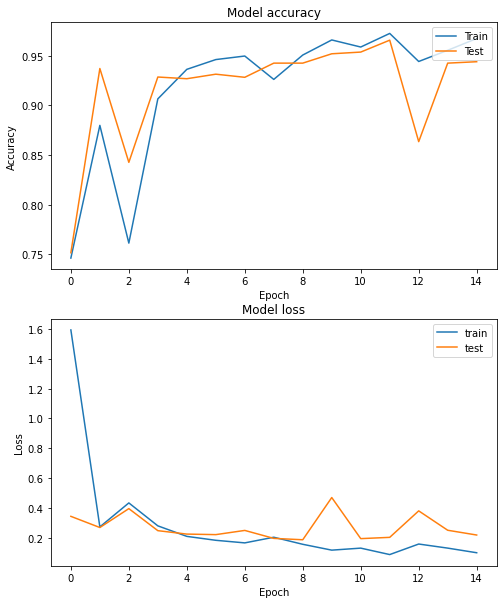

In [36]:
# Visualize accuracy
fig, axes = plt.subplots(2, 1, figsize=(8, 10))


axes[0].plot(base_history.history['accuracy'])
axes[0].plot(base_history.history['val_accuracy'])
axes[0].set_title('Model accuracy')
axes[0].set_ylabel('Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].legend(['Train', 'Test'], loc='upper right')

axes[1].plot(base_history.history['loss'])
axes[1].plot(base_history.history['val_loss'])
axes[1].set_title('Model loss')
axes[1].set_ylabel('Loss')
axes[1].set_xlabel('Epoch')
axes[1].legend(['train', 'test'], loc='upper right')


In [37]:
# Export model
base_model.save('models/base_cnn')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: models/base_cnn\assets
